In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa
import random
import copy

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [2]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
data_folder = "D:/korean-single-speaker-speech-dataset/kss"

with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [3]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [4]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [5]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

unicode_jamo_list = ['-'] + unicode_jamo_list

print(unicode_jamo_list)
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [6]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [7]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [8]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

In [9]:
class ResidualGRU(nn.Module):
    def __init__(self, D_in, bidirectional=True):
        super(ResidualGRU, self).__init__()
        self.gru = nn.GRU(D_in, int(D_in/2), bidirectional=bidirectional, batch_first=True)
        self.relu = nn.ReLU()
        
    def forward(self, input_tensor):
        
#         print("Residual Input: {}".format(input_tensor.shape))
        gru_output, _ = self.gru(input_tensor)
        activated = self.relu(gru_output)  
#         print("Residual Output: {}".format(activated.shape))
        output_tensor = torch.add(activated, input_tensor)
        
        return output_tensor

In [10]:
class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.H = H
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
            
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        self.H = H
        
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, D_out, batch_first=True)
        
        self.fc = nn.Linear(D_out, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        output_tensor,_ = self.gru(input_tensor)

        output_tensor = self.fc(output_tensor)
        
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.H = H
        
        self.encoder = Encoder(D_in, H).to(device)
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)
        self.embedding_optimizer = optim.Adam(self.embedding_layer.parameters(), lr=0.001)

#         self.criterion = nn.CrossEntropyLoss(reduction='none').to(device)
        self.ctc_loss = nn.CTCLoss().to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)

        pred_tensor = self.decoder(encoded_tensor)
            
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
#         print(pred_tensor)

        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
        
        self.embedding_layer.train()
        self.encoder.train()
        self.decoder.train()
    
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(80, 1024, 512)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [12]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
#         self.shuffle_step = 4
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
        
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
        
            pad_random = np.random.randint(0, 5)
            
            if pad_random > 0:
                offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                target = torch.cat((offset, target), 1)
                
            target = target + (torch.rand(target.shape) - 0.5) / 20
        
            target = torch.clamp(target, min=0.0, max=1.0)
            
            batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list


In [13]:
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [14]:
preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)

In [15]:
def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

In [16]:
lost_history = list()
lost_history = np.load('model_saved/loss_history______.npy').tolist()

In [28]:
# preloader.initialize_batch()
# preloader.get_batch()

08-31 03:54:30
Mean Loss: 0.019872700432327386
----------------------------------------------------
08-31 03:58:14
Mean Loss: 0.02005818979826323
----------------------------------------------------
08-31 03:58:34
Mean Loss: 0.019983484013997473


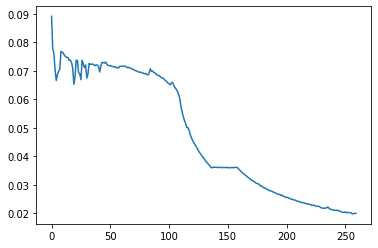

최-그-----------------을 설-무-초-서-ᄋ 혈-가ᅡ   -----누-닥저-에 과-항-수-가   ------사ᅢ  기정-에 반대ᄒ-는 것을ᅩᅥ ᄃ다-탈------------------------------------------------ᄂ--ᅢᆻ다.<eos>
최그을 설무초서ᄋ 혈가 누닥저에 과항수가 사ᅢ 기정에 반대ᄒ는 것을ᅩᅥ 다탈냈다.<eos>
최근의 설문 조사 결과 응답자의 과반수가 새 규정에 반대하는 것으로 나타났다.<eos>-----------------


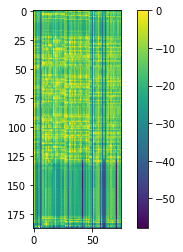

----------------------------------------------------
08-31 03:58:55
Mean Loss: 0.019835677880645573
----------------------------------------------------
08-31 03:59:15
Mean Loss: 0.019559628599559696


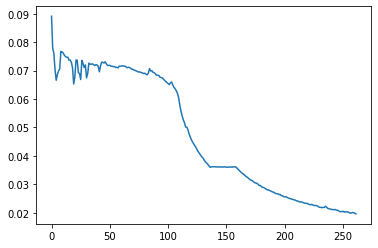

신시----------------------수-고 꿀-테ᅢ   -----기ᄅ려으 성하ᄅ라ᄌ지 아기를 글ᄌ정에ᄉ움ᆯᆯ ᅡᅡᆯᄅᆯᄃᄃ드 이 대ᄋ어-  이-강ᄋ이----------------------------------------------------------ᆸ니다.<eos>
신시수고 꿀테ᅢ 기려으 성하라지 아기를 글정에ᄉ움ᆯ ᅡᆯᄅᆯ드 이 대어 이강입니다.<eos>
심사숙고 끝에 귀하를 선발하지 않기로 결정했음을 알려드리게 되어 유감입니다.<eos>--------------


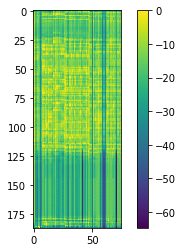

----------------------------------------------------
08-31 03:59:36
Mean Loss: 0.01961843879333857
----------------------------------------------------
08-31 03:59:56
Mean Loss: 0.019345670514022792


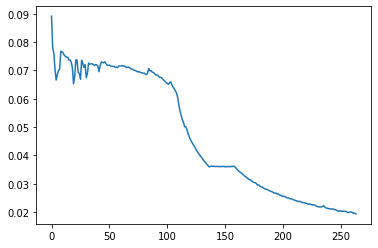

처-그--------------------ᄋ이고  ᅵ 이사ᅡ핬을 ᄄ떼ᅦ     -----거-러ᅥ서ᅥ 다ᅡ는 멀리에 시-뗘-부 나ᅡ기-가 있따-는 게   ----참-  좋------------------------------었어요.<eos>
처그이고 ᅵ 이사핬을 떼 거러서 다는 멀리에 시뗘부 나기가 있따는 게 참 좋었어요.<eos>
처음 이곳에 이사 왔을 때 걸어서 닿는 거리에 식료품 가게가 있다는 게 참 좋았어요.<eos>----------


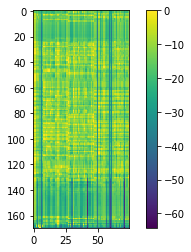

----------------------------------------------------
08-31 04:00:17
Mean Loss: 0.01949919550972019
----------------------------------------------------
08-31 04:00:38
Mean Loss: 0.019420411391556532


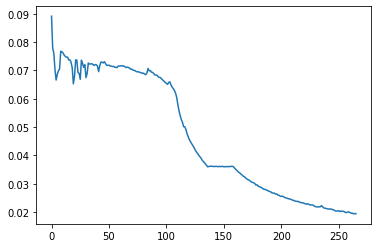

이 여-------------------------의  두-새--살에   ------분사-에서ᅥ 기-술-자-들이  파-견 데-ᅧᅥ   ----형엘 징와- 들 괄  혀-벅하ᅡ---------------------------------------------ᆸ니다.<eos>
이 여의 두새살에 분사에서 기술자들이 파견 데ᅧᅥ 형엘 징와 들 괄 혀벅합니다.<eos>
일 년에 두세 차례 본사에서 기술자들이 파견되어 현지 직원들과 협업합니다.<eos>-------------------


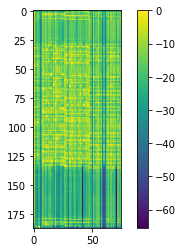

----------------------------------------------------
08-31 04:00:58
Mean Loss: 0.01923519329547004
----------------------------------------------------
08-31 04:01:19
Mean Loss: 0.019345104567816733


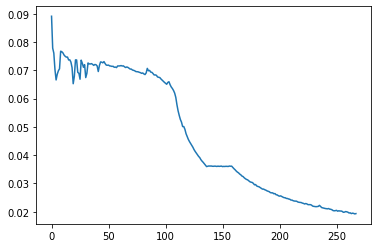

저-는---------------  아-침 ᄆ많니 갈려-서    ---ᄉᄉᄉᄅᆯ은 사라ᅡᆷ드-에-ᄀ기   마암ᆷ일여-는-데   ---많ᆭ는 시-ᅡᅡᆫ이 걸----------------------------------------------------------여요.<eos>
저는 아침 많니 갈려서 ᄉᄅᆯ은 사람드에기 마암일여는데 많는 시ᅡᆫ이 걸여요.<eos>
저는 낯을 많이 가려서 새로운 사람들에게 마음을 여는 데 많은 시간이 걸려요.<eos>----------------


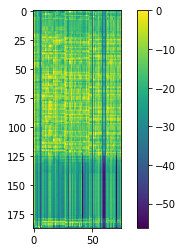

----------------------------------------------------
08-31 04:01:40
Mean Loss: 0.019135595815459327
----------------------------------------------------
08-31 04:02:01
Mean Loss: 0.019032557730103494


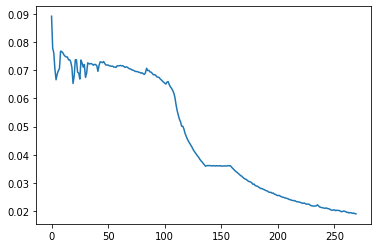

볼이---------------러그  고-담 났단는 초-의 신-넌는  ----오ᅩᆫ수과 안 나ᅡᆼ-어-다   -남ᆼ감으 안ᄃᄃᆯᆯ 디이------------------------------------------------------------------ᆸ니다.<eos>
볼이러그 고담 났단는 초의 신넌는 온수과 안 낭어다 남ᆼ감으 안ᄃᆯ 디입니다.<eos>
보일러가 고장 났다는 초기 신호는 온수가 안 나오거나 난방이 안 될 때입니다.<eos>-----------------


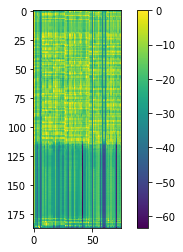

----------------------------------------------------
08-31 04:02:22
Mean Loss: 0.018883389132838393
----------------------------------------------------
08-31 04:02:42
Mean Loss: 0.01961980732635072


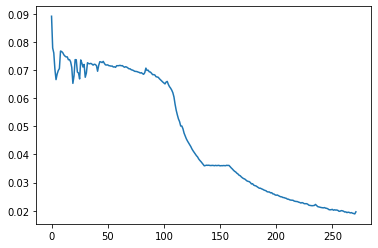

이 수----------------ᆨ의 ᄉᄉ실의  사리ᅵ숫-자-는  -이-애 자-기 시--자ᄋ   새-애 이ᄃ다  -------------바- 숙-자-이 아-복-타-이-다  ---------이-ᅵ -순ᆫ---------------------------------ᄃᆫ.<eos>
이 숙의 실의 사리숫자는 이애 자기 시자ᄋ 새애 이다 바 숙자이 아복타이다 이ᅵ 순ᄃᆫ.<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


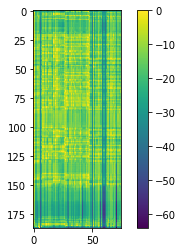

----------------------------------------------------
08-31 04:03:04
Mean Loss: 0.019336287737258148
----------------------------------------------------
08-31 04:03:24
Mean Loss: 0.018786710971353926


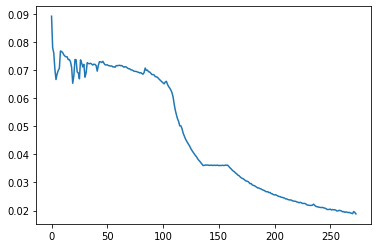

우-리----------------------는ᆫ  ----뫼-극이 구-로ᅩ-자드ᅳᆯ에  건긱을 구-후-하-기 이-에   -------기-슥-게-서  츤산을 다ᅡ알-곳시--------------------------------------------ᆸ니다.<eos>
우리는 뫼극이 구로자들에 건긱을 구후하기 이에 기슥게서 츤산을 다알곳십니다.<eos>
우리는 외국인 근로자들의 권익을 보호하기 위해 계속해서 최선을 다할 것입니다.<eos>--------------


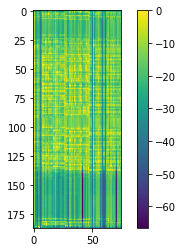

----------------------------------------------------
08-31 04:03:47
Mean Loss: 0.018942627676664648
----------------------------------------------------
08-31 04:04:07
Mean Loss: 0.018818745637032747


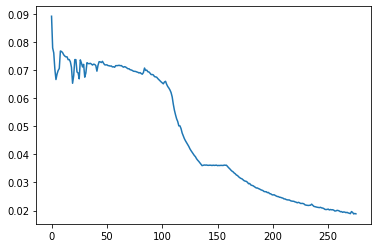

부-모---------가 저ᄌ지르ᄂ는  한  시--수-줌 하ᅡ가-는   ---------장ᄀ기 야-기ᄅ을  ᄃ--ᄃ다른 지 ᄋ아이-마  비-구 한ᅳᆫ 것ᆺ----------------------------------------이다.<eos>
부모가 저지르는 한 시수줌 하가는 장기 야기ᄅ을 ᄃ다른 지 아이마 비구 한ᅳᆫ 것이다.<eos>
부모가 저지르는 큰 실수 중 하나는 자기 아이를 다른 집 아이와 비교하는 것이다.<eos>-----------------


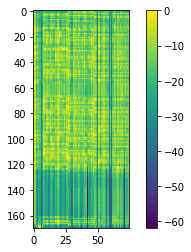

----------------------------------------------------
08-31 04:04:28
Mean Loss: 0.01849467371931247
----------------------------------------------------
08-31 04:04:49
Mean Loss: 0.01879724288473201


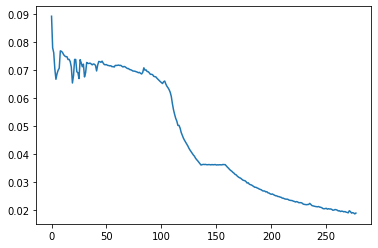

여-러-----------ᄇᆫ는 이ᅵ곳-에-서-   ------자ᅡ--이ᅵ  -------때---까-  -----률 릭-근  ---라-랑ᆼ한 좀ᄋ이  푼틀를  보실 수  -있------------------------------------------습니다.<eos>
여러ᄇᆫ는 이곳에서 자이 때까 률 릭근 라랑한 좀이 푼틀를 보실 수 있습니다.<eos>
여러분은 이곳에서 장미, 백합, 튤립 등 다양한 종류의 꽃들을 보실 수 있습니다.<eos>----------


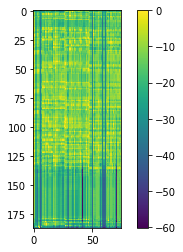

----------------------------------------------------
08-31 04:05:10
Mean Loss: 0.018793816435343894
----------------------------------------------------
08-31 04:05:31
Mean Loss: 0.01858614525594613


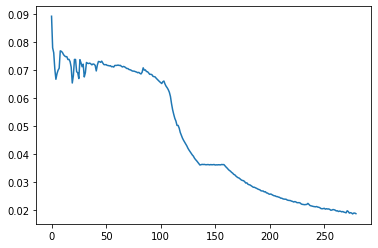

브-모-----과- 저-지르느ᅳᆫ -흔  시--수-ᄌ주 ᄒ하나-는   ---------장-기 야ᄒ에르ᅳᆯ  ---다-란ᆫ지-아ᅡ이-바  비-루ᄒ하는 것ᄉ-------------------------------------------------------------ᅵ다.<eos>
브모과 저지르는 흔 시수주 하나는 장기 야ᄒ에를 다란지아이바 비루하는 것시다.<eos>
부모가 저지르는 큰 실수 중 하나는 자기 아이를 다른 집 아이와 비교하는 것이다.<eos>-----------------


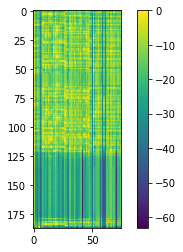

----------------------------------------------------
08-31 04:05:52
Mean Loss: 0.018709249331862774
----------------------------------------------------
08-31 04:06:12
Mean Loss: 0.018517515884308965


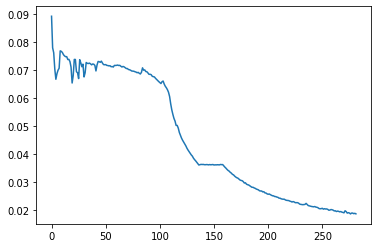

여-러------------분는 이 ᅩᅥᆺ세ᄉ서-,   -----ᄌ자--미,   ------배---가-  ----티ᅲ- 히--튼  ---다ᅡ앙한ᆫ송이이 고ᅳ 트-를 봇실 수 --있-----------------------------------------습니다.<eos>
여러분는 이 ᅩᅥᆺ세서, 자미, 배가 티ᅲ 히튼 다앙한송이이 고ᅳ 트를 봇실 수 있습니다.<eos>
여러분은 이곳에서 장미, 백합, 튤립 등 다양한 종류의 꽃들을 보실 수 있습니다.<eos>----------


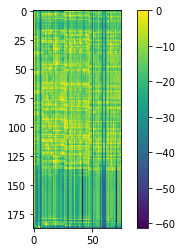

----------------------------------------------------
08-31 04:06:33
Mean Loss: 0.018246968283803754
----------------------------------------------------
08-31 04:06:54
Mean Loss: 0.0180240138425164


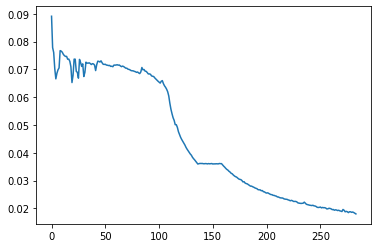

우-리--------------는ᆫ 창북이  곡인 언에   -해ᄉ서를 설히ᅵ-팡이-해   ----많는 내곡긴ᆫ드를 지-웡이ᄋ----ᆻ--------------------------------------------습니다.<eos>
우리는 창북이 곡인 언에 해서를 설히팡이해 많는 내곡긴드를 지웡이ᄋᆻ습니다.<eos>
우리는 십구백구십 년에 회사를 설립한 이래 많은 외국인들을 지원해 왔습니다.<eos>------------


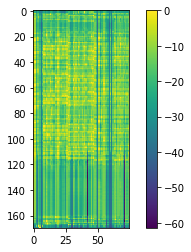

----------------------------------------------------
08-31 04:07:15
Mean Loss: 0.018756432768298227
----------------------------------------------------
08-31 04:07:35
Mean Loss: 0.01818909364242852


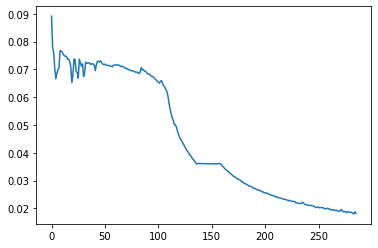

저-희----------- 의-장이ᅴ 모-든 품 목이ᅵ   ---이-번-질에 -체-ᄀ고   ---사-십 폇승트ᅳ-가ᅡ-지ᅵ  하-림-함ᄆ매를ᄒ하-----------------------------------------------------------ᆸ니다.<eos>
저희 의장이ᅴ 모든 품 목이 이번질에 체고 사십 폇승트가지 하림함매를합니다.<eos>
저희 매장의 모든 품목이 이번 주에 최고 삼십 퍼센트까지 할인 판매를 합니다.<eos>-----------------


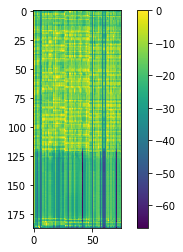

----------------------------------------------------
08-31 04:07:56
Mean Loss: 0.01825002582999902
----------------------------------------------------
08-31 04:08:17
Mean Loss: 0.018464152707907775


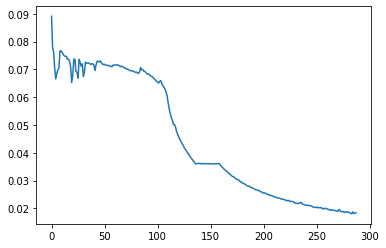

기-지---------- 부-이 게속 들ᅥᅥ오ᄆ만서ᅥ   --오-오ᄅ래는ᄌ저자  고보 이ᅵ고  ᅮᆨ ᅡᅡ다ᅡ을 사ᅡ시을  ᅦᅦ 달--------------------------------------------------------었어요.<eos>
기지 부이 게속 들ᅥ오만서 오오래는저자 고보 이고 ᅮᆨ ᅡ다을 사시을 ᅦ 달었어요.<eos>
기증품이 계속 들어오면서 우리는 저장 공간이 부족하다는 사실을 깨달았어요.<eos>----------------


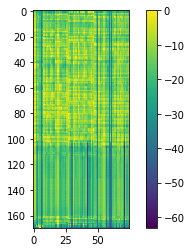

----------------------------------------------------
08-31 04:08:37
Mean Loss: 0.01816114265919434
----------------------------------------------------
08-31 04:08:57
Mean Loss: 0.017672989498589014


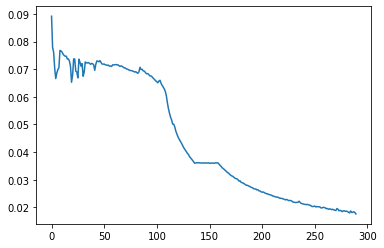

우-리------------는ᆫ 정고-으  고시ᅵ 년ᆫ에   -푀-사ᄅ으 ᄉ서-립하ᅡ-이ᄋ에   ---만은 개곡견ᄃᄃ-를 지-언이ᄋ--았----------------------------------------------습니다.<eos>
우리는 정고으 고시 년에 푀사ᄅ으 서립하이에 만은 개곡견ᄃ를 지언이ᄋ았습니다.<eos>
우리는 십구백구십 년에 회사를 설립한 이래 많은 외국인들을 지원해 왔습니다.<eos>------------


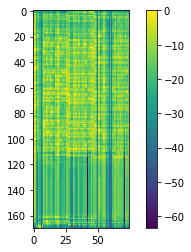

----------------------------------------------------
08-31 04:09:18
Mean Loss: 0.018434853666320708
----------------------------------------------------
08-31 04:09:38
Mean Loss: 0.01820215258349346


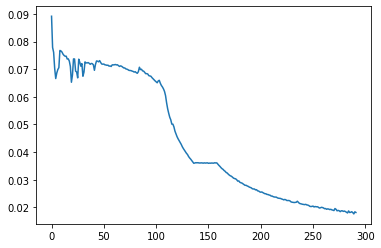

국주------------------- 언합에  문식 건어-는ᆫ  ------아-하--버-  ---------준-부-어-,  -------영ᄋ어,  --------블어요,  -------어-지-ᄋᄋ-요,   -----ᅮ-표-이-더----------------이다.<eos>
국주 언합에 문식 건어는 아하버 준부어, 영어, 블어요, 어지ᄋ요, ᅮ표이더이다.<eos>
국제연합의 공식 언어는 아랍어, 중국어, 영어, 불어, 러시아어, 스페인어이다.<eos>-----------------


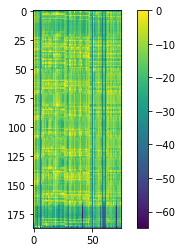

----------------------------------------------------
08-31 04:09:58
Mean Loss: 0.01816185623646591
----------------------------------------------------
08-31 04:10:19
Mean Loss: 0.01782383630059215


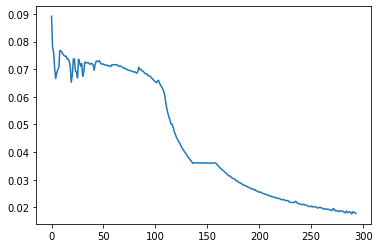

사-람------------ᅡᅡᆫᅳᆫ 머-이 있는 사람을 보ᄅᄋᆯᆯᅳ-데   ---솔을 옴목항에  만드ᄅ어  이--가-에 대----------------------------------------------------------------------------ᆸ니다.<eos>
사람ᅡᆫᅳᆫ 머이 있는 사람을 보ᄅᄋᆯᅳ데 솔을 옴목항에 만드ᄅ어 이가에 댑니다.<eos>
사람들은 멀리 있는 사람을 부를 때 손을 오목하게 만들어 입가에 댑니다.<eos>-------------------


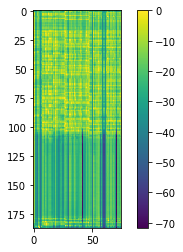

----------------------------------------------------
08-31 04:10:40
Mean Loss: 0.018083582787202845
----------------------------------------------------
08-31 04:11:00
Mean Loss: 0.018361593079387954


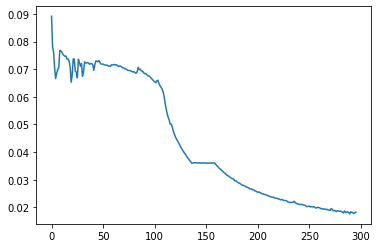

저-희-------------- 믜-장에  모-든 퐁 옥이    --ᄋ이-번ᄌ지외  ᄎ체-고    ---산십 펏샌특-까--지   하-른 함ᄆ여를 하--------------------------------------------------------ᆸ니다.<eos>
저희 믜장에 모든 퐁 옥이 이번지외 체고 산십 펏샌특까지 하른 함ᄆ여를 합니다.<eos>
저희 매장의 모든 품목이 이번 주에 최고 삼십 퍼센트까지 할인 판매를 합니다.<eos>-----------------


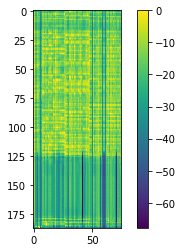

----------------------------------------------------
08-31 04:11:22
Mean Loss: 0.017942259104807727
----------------------------------------------------
08-31 04:11:42
Mean Loss: 0.01771666920913946


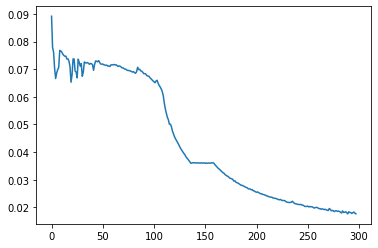

신사--------------------ᆫ 숙금 ᅳᅳ-ᄐ에   ----기기ᄅᄅ르 상가ᄅ라지  아ᄀᄀ글 블ᆯ정히ᅵ승ᅳᅳᆯ ᅡᆯᄅᄅᆯᄃ드딜 대여ᅥ   임 함ᅵᅵ-----------------------------------------ᆸ니다.<eos>
신산 숙금 ᅳᄐ에 기기르 상가라지 아글 블정히승ᅳᆯ ᅡᆯᄅᆯ드딜 대여ᅥ 임 함ᅵᆸ니다.<eos>
심사숙고 끝에 귀하를 선발하지 않기로 결정했음을 알려드리게 되어 유감입니다.<eos>--------------


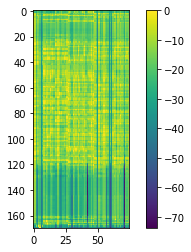

----------------------------------------------------
08-31 04:12:04
Mean Loss: 0.017568739392656615
----------------------------------------------------
08-31 04:12:25
Mean Loss: 0.01793097522441228


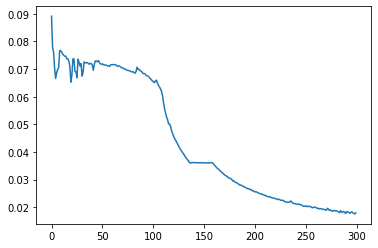

이 수--------------- 의 ᄉᄉ실의 서-리 숫-자-는  -이-래 자-리 숫-자아  새-래-예다ᅡ --------------ᅡᅡ  숙-짜-이 하-곱 타-이-다  ----------ᅵ일 숨-----------------------------------ᄅᆫ.<eos>
이 수 의 실의 서리 숫자는 이래 자리 숫자아 새래예다 ᅡ 숙짜이 하곱 타이다 ᅵ일 숨ᄅᆫ.<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


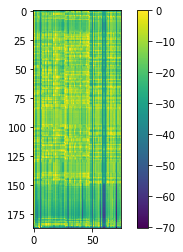

----------------------------------------------------
08-31 04:12:45
Mean Loss: 0.017768666784745733
----------------------------------------------------
08-31 04:13:06
Mean Loss: 0.017642970099644325


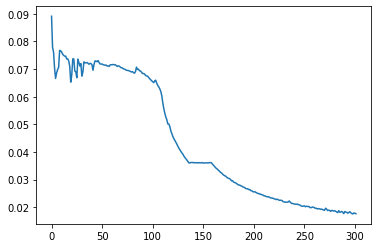

우-리-----------------------는ᆫ  ----뫼-국긴 그-로-자드ᅳᆯ에  건닙을 부-구ᄒ하-기 이-헤   ------게-숙베 서 어 젠산을 바-알 곳이-------------------------------------------ᆸ니다.<eos>
우리는 뫼국긴 그로자들에 건닙을 부구하기 이헤 게숙베 서 어 젠산을 바알 곳입니다.<eos>
우리는 외국인 근로자들의 권익을 보호하기 위해 계속해서 최선을 다할 것입니다.<eos>--------------


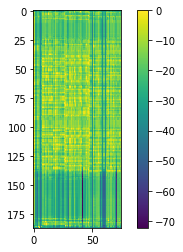

----------------------------------------------------
08-31 04:13:27
Mean Loss: 0.01755089714641621
----------------------------------------------------
08-31 04:13:47
Mean Loss: 0.017606796427773463


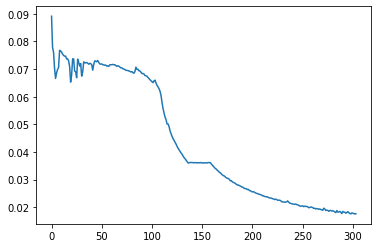

죄-금---------------- 복시-이 다ᄋᄋᄋ 패ᅢ핵 ᄒᆫ적일 나ᄀ고 않녀-지-며-서ᅥ   ---복식잉하느ᅳᆫ여ᅧ-아ᄃ드ᄅ이  --닐고ᅩ ------------------------------------------있어요.<eos>
죄금 복시이 다ᄋ 패핵 ᄒᆫ적일 나고 않녀지며서 복식잉하는여아드ᄅ이 닐고 있어요.<eos>
최근 복싱이 다이어트에 효과적이라고 알려지면서 복싱을 하는 여자들이 늘고 있어요.<eos>-----------


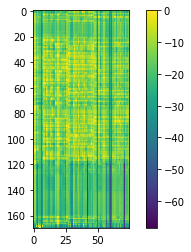

----------------------------------------------------
08-31 04:14:08
Mean Loss: 0.0176937170311861
----------------------------------------------------
08-31 04:14:29
Mean Loss: 0.017265123463151334


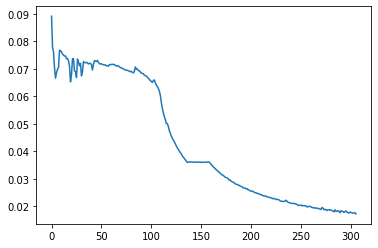

이- ᄂ--------------------------ᆫ에 두-쇠--찰에   ------분사-에ᄉ서  기수ᅮᆯ자ᅡ들인 파-견 대-어    ---형즐 징권 들-가  혀-벅ᆨ하ᅡ---------------------------ᆸ니다.<eos>
이 ᄂᆫ에 두쇠찰에 분사에서 기술자들인 파견 대어 형즐 징권 들가 혀벅합니다.<eos>
일 년에 두세 차례 본사에서 기술자들이 파견되어 현지 직원들과 협업합니다.<eos>-------------------


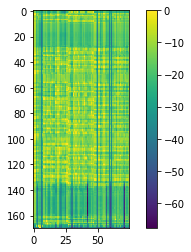

----------------------------------------------------
08-31 04:14:49
Mean Loss: 0.017354063870256443
----------------------------------------------------
08-31 04:15:10
Mean Loss: 0.017520326889133162


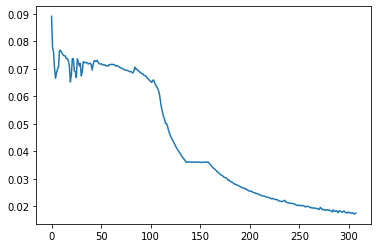

많은--------------  겨-오    ---툴요 소-서ᅥᆯ에-서     ---대--겅이-아 주ᄋ인공이 지-걱은ᆫ  ------구-서-애ᄋ에-서ᅥᅥ  중요한 요  ᄉ-----------------------------------------------ᅥ다.<eos>
많은 겨오 툴요 소설에서 대겅이아 주인공이 지걱은 구서애에서 중요한 요 서다.<eos>
많은 경우 추리 소설에서 배경이나 주인공의 직업은 구성에 있어 중요한 요소다.<eos>---------------


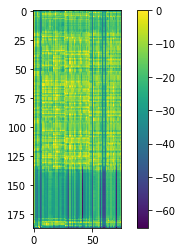

----------------------------------------------------
08-31 04:15:30
Mean Loss: 0.01704712213108753
----------------------------------------------------
08-31 04:15:51
Mean Loss: 0.017831160941808765


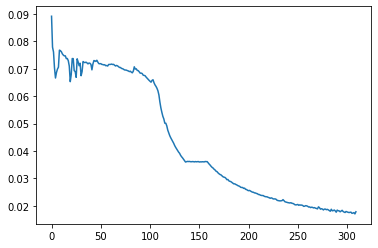

기-지----------- 붐이 게속 들러어-면-서   ----오-리-는 저장ᆫ봉강이 고족ᆨ가당을 사시ᅵᄋ을 대-다-------------------------------------------------------------------------았어요.<eos>
기지 붐이 게속 들러어면서 오리는 저장ᆫ봉강이 고족가당을 사시을 대다았어요.<eos>
기증품이 계속 들어오면서 우리는 저장 공간이 부족하다는 사실을 깨달았어요.<eos>----------------


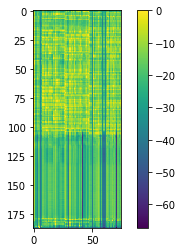

----------------------------------------------------
08-31 04:16:12
Mean Loss: 0.017310121369731674
----------------------------------------------------
08-31 04:16:32
Mean Loss: 0.017072270869299574


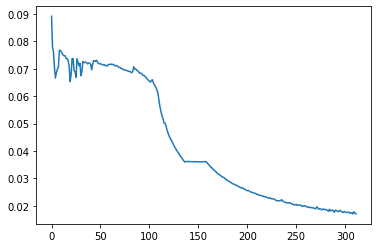

나-는---------------------ᄅᄂ  이--사-가  -----자-기- 가-죽--종   ---누-문갈르 수-수ᄅᄅᄅ-는 것ᄉ이   ---디-도-덕-중이ᄅ라고 생각----------------------------------------------ᅡᆫ다.<eos>
나는ᄅᄂ 이사가 자기 가죽종 누문갈르 수수ᄅ는 것ᄉ이 디도덕중이라고 생각ᅡᆫ다.<eos>
나는 의사가 자기 가족 중 누군가를 수술하는 것이 비도덕적이라고 생각한다.<eos>-------------------


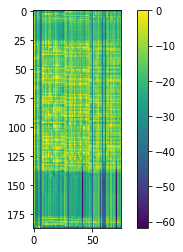

----------------------------------------------------
08-31 04:16:52
Mean Loss: 0.01720162528075238
----------------------------------------------------
08-31 04:17:12
Mean Loss: 0.017168196088501113


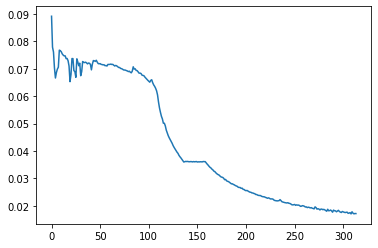

사-함----------- ᅡᆫ는 먼이 있는 사람을 보ᄅ를  떼   ---솜을 오ᄆ무 간에  만들어  잇-가-에 ᄃ되---------------------------------------------------------------------------ᆸ니다.<eos>
사함 ᅡᆫ는 먼이 있는 사람을 보를 떼 솜을 오무 간에 만들어 잇가에 됩니다.<eos>
사람들은 멀리 있는 사람을 부를 때 손을 오목하게 만들어 입가에 댑니다.<eos>-------------------


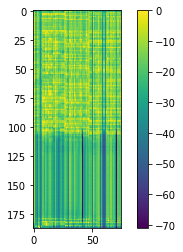

----------------------------------------------------
08-31 04:17:33
Mean Loss: 0.017145212966640937
----------------------------------------------------
08-31 04:17:54
Mean Loss: 0.0167148753596032


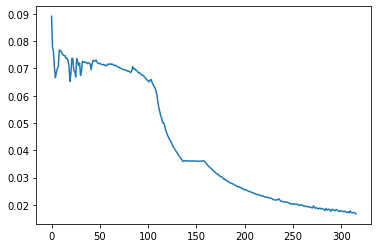

사-람----------는는 멀이 있는 사람을 부ᄅ을 ᄄ떼   --수ᅩᆫ을 엄목환에  만들어  이--까ᅡ일ᄃ되----------------------------------------------------------------------------ᆸ니다.<eos>
사람는는 멀이 있는 사람을 부ᄅ을 떼 수ᅩᆫ을 엄목환에 만들어 이까일됩니다.<eos>
사람들은 멀리 있는 사람을 부를 때 손을 오목하게 만들어 입가에 댑니다.<eos>-------------------


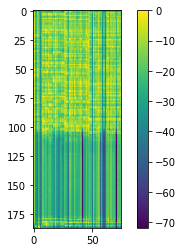

----------------------------------------------------
08-31 04:18:14
Mean Loss: 0.016658735116018116
----------------------------------------------------
08-31 04:18:35
Mean Loss: 0.016720958386700385


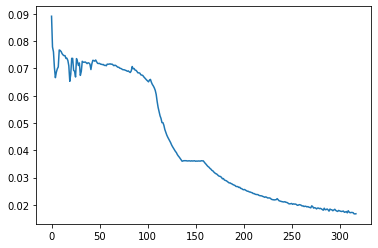

근뮤---------------- 시-간이 다ᅡᄌ죽드-ᄆ면  ----그-오  환 경-ᄀ가   그로ᅩ자들을  살-일 질이   --개-선-대-것이-------------------------------------------ᆸ니다.<eos>
근뮤 시간이 다죽드면 그오 환 경가 그로자들을 살일 질이 개선대것입니다.<eos>
근로 시간이 단축되면 근로 환경과 근로자들의 삶의 질이 개선될 것입니다.<eos>------------------


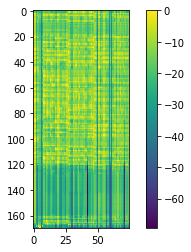

----------------------------------------------------
08-31 04:18:55
Mean Loss: 0.01689032101783038
----------------------------------------------------
08-31 04:19:15
Mean Loss: 0.017023930355842796


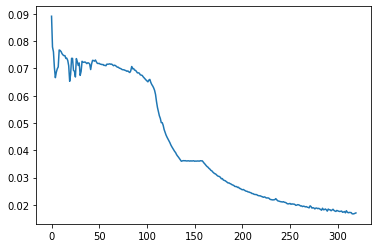

붕모-------ᅡᅡ 저-지ᄅ-는  -큰  실-수-ᄌ중하ᅡ가ᄋ는   ---------자ᅡ-기 아이-를ᆯ   --달른 질 아이-버  비기-허-는 거-------------------------------------------------------------시다.<eos>
붕모ᅡ 저지ᄅ는 큰 실수중하가ᄋ는 자기 아이를 달른 질 아이버 비기허는 거시다.<eos>
부모가 저지르는 큰 실수 중 하나는 자기 아이를 다른 집 아이와 비교하는 것이다.<eos>-----------------


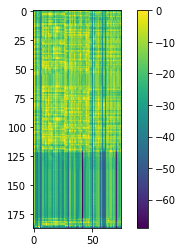

----------------------------------------------------
08-31 04:19:36
Mean Loss: 0.01704329759414457
----------------------------------------------------
08-31 04:19:56
Mean Loss: 0.016759358403023516


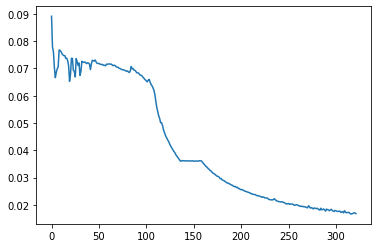

심ᄉ--------------------------슷부 끌-대ᅢ   ----ᄇ비려른 산바라ᅡ지 암끼를 ᄇᄇᆫ-정에ᄉ슴ᅳᆯᆯ다-래ᄃᄃ드에 ᄃ대여ᅥᅥ  이-범이ᅵ-------------------------------------ᅳᆸ니다.<eos>
심ᄉ슷부 끌대 비려른 산바라지 암끼를 ᄇᆫ정에슴ᅳᆯ다래드에 대여ᅥ 이범이ᅳᆸ니다.<eos>
심사숙고 끝에 귀하를 선발하지 않기로 결정했음을 알려드리게 되어 유감입니다.<eos>--------------


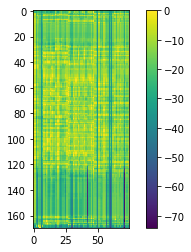

----------------------------------------------------
08-31 04:20:17
Mean Loss: 0.01710302092045024
----------------------------------------------------
08-31 04:20:37
Mean Loss: 0.016942762494767744


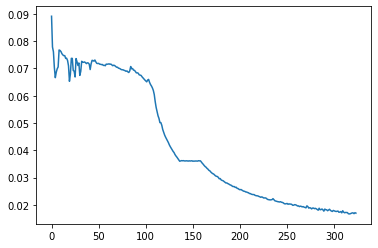

부-모--------가  저지-르느ᅳᆫ -큰 -실-스 ᄌ조  따ᅡᅡᅡ는   ---------자--기 아이ᅵ르ᅳᆯ   ---달은-지 마이-러  비-부-하는 거------------------------------------------이다.<eos>
부모가 저지르는 큰 실스 조 따는 자기 아이를 달은지 마이러 비부하는 거이다.<eos>
부모가 저지르는 큰 실수 중 하나는 자기 아이를 다른 집 아이와 비교하는 것이다.<eos>-----------------


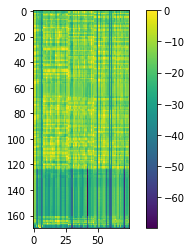

----------------------------------------------------
08-31 04:20:58
Mean Loss: 0.01643581050999612
----------------------------------------------------
08-31 04:21:19
Mean Loss: 0.016839273861589447


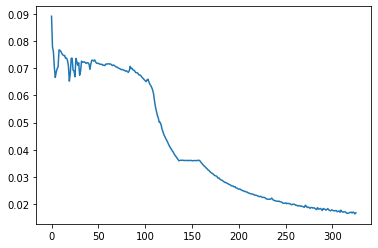

심시-------------------------슥보-둘-대-   -----비벼-아 산바-라ᄌᄌ 앙기를 뎔청ᆼ애ᄉ슴ᅳᆯᆯ ᅡᆯ래 든으  대ᄋ어ᅥ  이-함ᆷ이--------------------------------------ᆸ니다.<eos>
심시슥보둘대 비벼아 산바라ᄌ 앙기를 뎔청애슴ᅳᆯ ᅡᆯ래 든으 대어 이함입니다.<eos>
심사숙고 끝에 귀하를 선발하지 않기로 결정했음을 알려드리게 되어 유감입니다.<eos>--------------


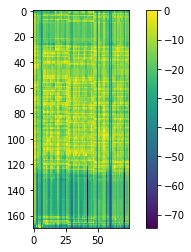

----------------------------------------------------
08-31 04:21:40
Mean Loss: 0.017137787072862926
----------------------------------------------------
08-31 04:22:00
Mean Loss: 0.016419959084920645


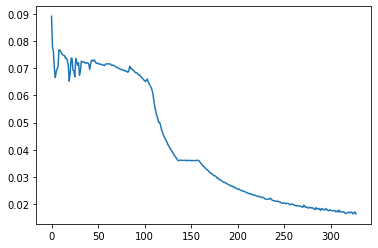

카-드-----------------을 부ᄉ수하ᅡ-건나  돈한당학-혀-오   -----즉ᄉ시  신고-해-서-   ----하-ᅳᅳᆯᅳᆯ ᄌ점주 식겨야 하-----------------------------------------------------------ᆸ니다.<eos>
카드을 부수하건나 돈한당학혀오 즉시 신고해서 하ᅳᆯᅳᆯ 점주 식겨야 합니다.<eos>
카드를 분실하거나 도난 당할 경우 즉시 신고해서 카드를 정지시켜야 합니다.<eos>--------------------


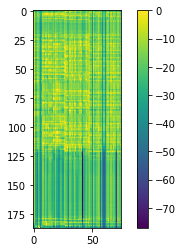

----------------------------------------------------
08-31 04:22:21
Mean Loss: 0.017065277180786674
----------------------------------------------------
08-31 04:22:41
Mean Loss: 0.016549064804309437


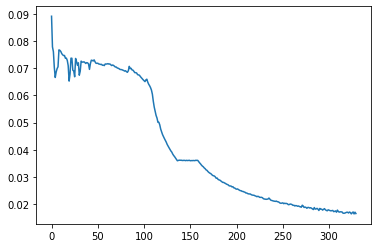

해-이------------------로-부--더  정연-경이 이-이 -대-어    --확ᄉ산느-는 거ᅥ-즐  방ᆫ-자ᅡ기ᅵ위-하  ᄂ누-력-ᅵ  있----------------------------------------------------------ᄋ--ᅥᆻ다.<eos>
해이로부더 정연경이 이이 대어 확산느는 거즐 방ᆫ자기위하 누력ᅵ 있었다.<eos>
해외로부터 전염병이 유입되어 확산되는 것을 방지하기 위한 노력이 있었다.<eos>-------------------


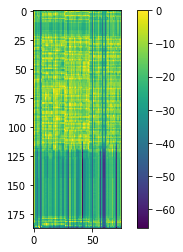

----------------------------------------------------
08-31 04:23:02
Mean Loss: 0.01698719164095853
----------------------------------------------------
08-31 04:23:23
Mean Loss: 0.016600396858975883


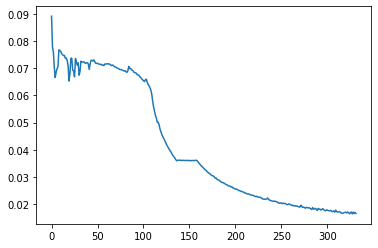

최-그------------------의 절 몬 조-살-멸 -가   -----운닥저-에 바-ᄇ변-수-가  ------ᅡ새 구-정의  방내하는 것을오 ᄃ다-다-------------------------------------------------ᄂ--ᅡᆻ다.<eos>
최그의 절 몬 조살멸 가 운닥저에 바변수가 ᅡ새 구정의 방내하는 것을오 다다났다.<eos>
최근의 설문 조사 결과 응답자의 과반수가 새 규정에 반대하는 것으로 나타났다.<eos>-----------------


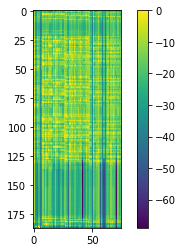

----------------------------------------------------
08-31 04:23:44
Mean Loss: 0.016758977115655074
----------------------------------------------------
08-31 04:24:04
Mean Loss: 0.017342090285862973


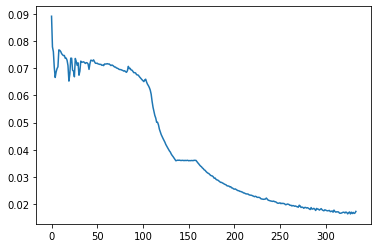

징 -----------------게ᄋ에 핼외 허-ᅵᅵ늘 설리-하-고--잔 하-며ᅧ   -----고-래라ᅡ 해야ᅡᅡᅦᄉᄉ사ᄋᄋᆨ이ᅵ   며ᅧᆨ-갈이 -있-------------------------------------------------------------습니다.<eos>
징 게에 핼외 허ᅵ늘 설리하고잔 하며 고래라 해야ᅡᅦ사ᄋᆨ이 멱갈이 있습니다.<eos>
중국에 해외 법인을 설립하고자 한다면 고려해야 할 사항이 몇 가지 있습니다.<eos>-----------------


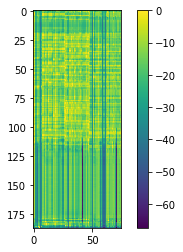

----------------------------------------------------
08-31 04:24:25
Mean Loss: 0.016820816805092956
----------------------------------------------------
08-31 04:24:46
Mean Loss: 0.017149429405636664


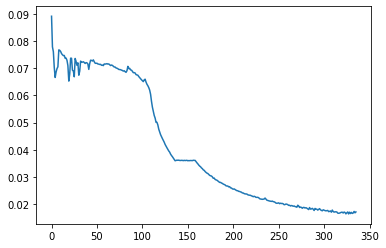

중구------------------ᄀᄋ에 ᄒ해의 폽블열 설이 하ᄀ고ᄌ 잔ᆻ다-며ᅧᆫ  -----ᄀ고ᄅ력 애ᄋ야할 사-항이    멱-까ᅡ   --있-----------------------------------------------------------습니다.<eos>
중구ᄀ에 해의 폽블열 설이 하고ᄌ 잔ᆻ다면 고력 애야할 사항이 멱까 있습니다.<eos>
중국에 해외 법인을 설립하고자 한다면 고려해야 할 사항이 몇 가지 있습니다.<eos>-----------------


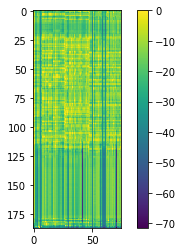

----------------------------------------------------
08-31 04:25:06
Mean Loss: 0.017064876818764264
----------------------------------------------------
08-31 04:25:27
Mean Loss: 0.01737675819085021


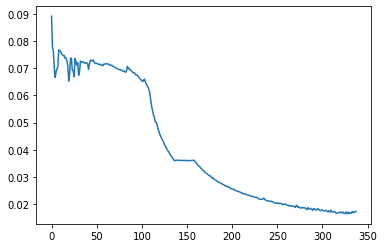

그-녀-------------는 자-식의 재-능을 이-용-에   ---명-희 ᅡ  불를 수ᅮᅮ 하니 ᄃ대는ᆫ  -가-무  갈-심ᄋᄋ    없---------------------------------------------ᄋ--ᅥᆻ다.<eos>
그녀는 자식의 재능을 이용에 명희 ᅡ 불를 수 하니 대는 가무 갈심ᄋ 없었다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


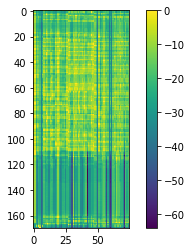

----------------------------------------------------
08-31 04:25:48
Mean Loss: 0.01685682648616366
----------------------------------------------------
08-31 04:26:08
Mean Loss: 0.016290438017162446


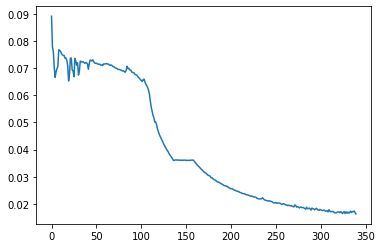

장례----------------------를 지-해의 한-다-는  거ᅥᆨ이 이-지는 난--다.  -----장-해-는 단ᆫ-지   -----복-련-적ᆨ긴 -작뵬 을-식------------------------------------------이다.<eos>
장례를 지해의 한다는 걱이 이지는 난다. 장해는 단지 복련적긴 작뵬 을식이다.<eos>
장례를 지내야 한다는 법이 있지는 않다. 장례는 단지 보편적인 작별 의식이다.<eos>-------------


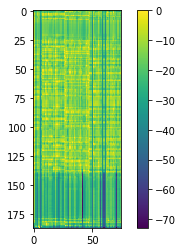

----------------------------------------------------
08-31 04:26:28
Mean Loss: 0.01622290714225467
----------------------------------------------------
08-31 04:26:48
Mean Loss: 0.016503365141731407


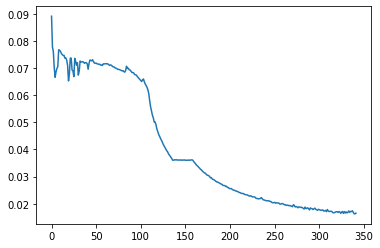

안으-----------------ᆫ 명우ᅩ   ---출이 수-선ᄋ에-서-   -----애-경이-나 지-이-봉이 지-겁은,  ------구-성이 있어ᅥᅥ ᄌ주요-한 겨  조---------------------------------------------다.<eos>
안은 명우ᅩ 출이 수선에서 애경이나 지이봉이 지겁은, 구성이 있어 주요한 겨 조다.<eos>
많은 경우 추리 소설에서 배경이나 주인공의 직업은 구성에 있어 중요한 요소다.<eos>---------------


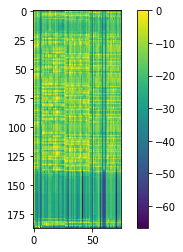

----------------------------------------------------
08-31 04:27:09
Mean Loss: 0.01635909951918412
----------------------------------------------------
08-31 04:27:29
Mean Loss: 0.016446956127052284


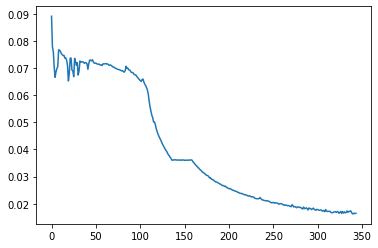

우-리--------------------느ᄂᆫᆫ   -----구-느을 모ᅩᅩ-애--따-나ᅡ   --ᄋ이리-를 장할에  골어ᅥᅥ 수있슬ᆯ거ᄅ러 생각---------------------------------------------했어요.<eos>
우리느ᄂᆫ 구느을 모애따나 이리를 장할에 골어 수있슬거러 생각했어요.<eos>
우리는 금요일 오후에 떠나 일요일 저녁에 돌아올 수 있을 거라 생각했어요.<eos>--------------------


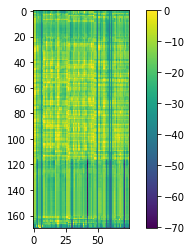

----------------------------------------------------
08-31 04:27:50
Mean Loss: 0.016270941917856756
----------------------------------------------------
08-31 04:28:10
Mean Loss: 0.016260163884610403


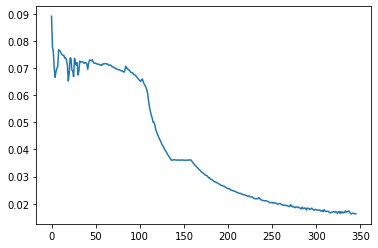

국제-------------------- 연합에  뭉실 건언는ᆫ  ------아-악-억   --------준-국어-,, -------영-어,   --------ᅮᆯᄅ어,   --------머-시ᄋ요-,,   ----수ᅮ파ᅡ이-넘--------------이다.<eos>
국제 연합에 뭉실 건언는 아악억 준국어, 영어, ᅮᆯᄅ어, 머시요, 수파이넘이다.<eos>
국제연합의 공식 언어는 아랍어, 중국어, 영어, 불어, 러시아어, 스페인어이다.<eos>-----------------


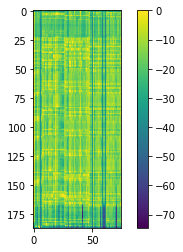

----------------------------------------------------
08-31 04:28:32
Mean Loss: 0.01585486179681341
----------------------------------------------------
08-31 04:28:52
Mean Loss: 0.01609317215773244


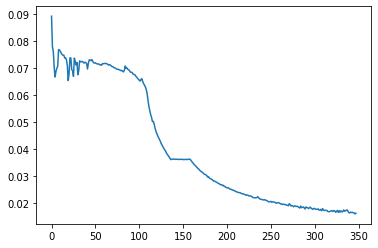

저-는--------------------이 고 지 이상았을 때ᅢᅦ     -----거-엇서  다-는 거ᄅ이에 심익푼 가ᄀ기가 있따ᅡ는 게   ----차ᅡᆷ  줗ᄋ---------------------------------------------왔어요.<eos>
저는이 고 지 이상았을 때ᅦ 거엇서 다는 거ᄅ이에 심익푼 가기가 있따는 게 참 줗ᄋ왔어요.<eos>
처음 이곳에 이사 왔을 때 걸어서 닿는 거리에 식료품 가게가 있다는 게 참 좋았어요.<eos>----------


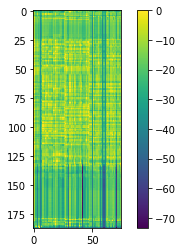

----------------------------------------------------
08-31 04:29:13
Mean Loss: 0.016631044926919428
----------------------------------------------------
08-31 04:29:34
Mean Loss: 0.017211713922475846


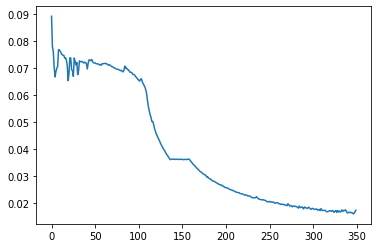

모-일---------------어아 고ᅩ장-나-다-는 초-기 시ᅵ-호-는  ----오- 수-ᅡ 안-나---거-나    남ᆷ방이 얀-달 디이ᅵ-----------------------------------------------------------------ᆸ니다.<eos>
모일어아 고장나다는 초기 시호는 오 수ᅡ 안나거나 남방이 얀달 디입니다.<eos>
보일러가 고장 났다는 초기 신호는 온수가 안 나오거나 난방이 안 될 때입니다.<eos>-----------------


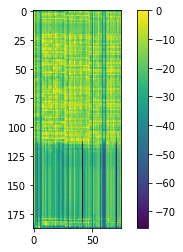

----------------------------------------------------
08-31 04:29:55
Mean Loss: 0.016363505250496846
----------------------------------------------------
08-31 04:30:16
Mean Loss: 0.016383918317599295


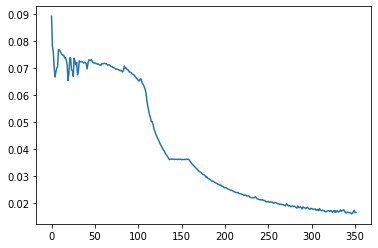

그  ------------------가-승-은  -----흔-산 인기-가 있을 -때   -------가--자-게   덤으선 ᅮᅮ애를  하제 연-앴따ᄀ고고 ᄉ서-으----------------------------------------------ᄒ--ᅢᆻ다.<eos>
그 가승은 흔산 인기가 있을 때 가자게 덤으선 ᅮ애를 하제 연앴따고고 서으했다.<eos>
그 가수는 한창 인기가 있을 때 갑자기 더 이상 노래를 하지 않겠다고 선언했다.<eos>---------------


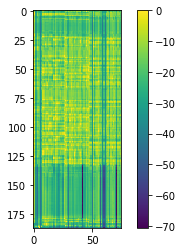

----------------------------------------------------
08-31 04:30:37
Mean Loss: 0.015827470672204934
----------------------------------------------------
08-31 04:30:58
Mean Loss: 0.015881234769847485


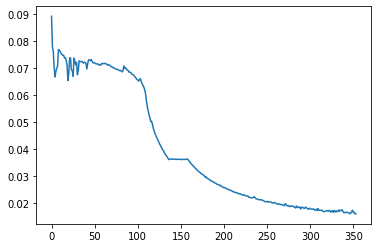

많은---------------- 경-오    ---술이 소-서--에-서-   ----여--경이-마 수-이-벙이 지-업은, ------구-서-이 있-어ᅥ  중이-한-여--소---------------------------------------------다.<eos>
많은 경오 술이 소서에서 여경이마 수이벙이 지업은, 구서이 있어 중이한여소다.<eos>
많은 경우 추리 소설에서 배경이나 주인공의 직업은 구성에 있어 중요한 요소다.<eos>---------------


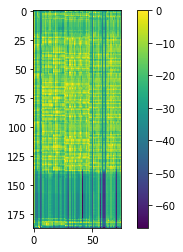

----------------------------------------------------
08-31 04:31:20
Mean Loss: 0.01614977312390767
----------------------------------------------------
08-31 04:31:41
Mean Loss: 0.016453267921354157


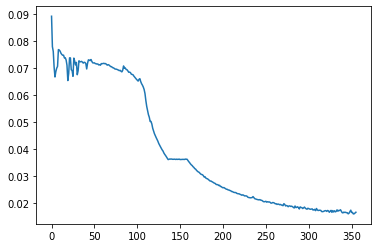

그-른------------- 시-근이  다-직-되-ᄆ면  ----그ᄅ-로 황-경-과-  ᄀ그로ᅥ자들으  사ᅡᆫ-일-칠ᅵᅵ   --개-선-들ᄀ거ᄌ이------------------------------------------------------------ᆸ니다.<eos>
그른 시근이 다직되면 그ᄅ로 황경과 그로ᅥ자들으 산일칠ᅵ 개선들거ᄌ입니다.<eos>
근로 시간이 단축되면 근로 환경과 근로자들의 삶의 질이 개선될 것입니다.<eos>------------------


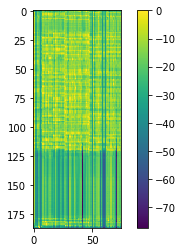

----------------------------------------------------
08-31 04:32:03
Mean Loss: 0.0162641214039964
----------------------------------------------------
08-31 04:32:24
Mean Loss: 0.01588252308627807


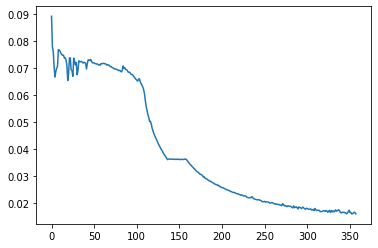

저-희-----------  ᄋ--장이  모-든 픙 목-이   ---이-번 주-에 -체-고    ---섬십 펏슨특-까--지   -하른 한 멸ᅳᆯ 하----------------------------------------------------------ᆸ니다.<eos>
저희 ᄋ장이 모든 픙 목이 이번 주에 체고 섬십 펏슨특까지 하른 한 멸ᅳᆯ 합니다.<eos>
저희 매장의 모든 품목이 이번 주에 최고 삼십 퍼센트까지 할인 판매를 합니다.<eos>-----------------


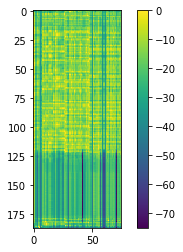

----------------------------------------------------
08-31 04:32:46
Mean Loss: 0.015914206554440005
----------------------------------------------------
08-31 04:33:07
Mean Loss: 0.016042817489257455


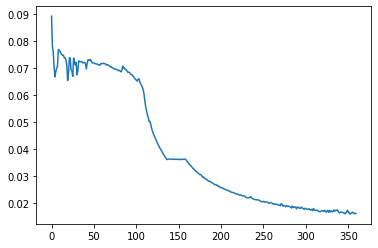

우-리-------------------는ᆫ     -----구-외ᄋ에 오 애애--더-나-    -얘-이랄ᄌᄌᆼ알에    돌어ᅥᅥ  ᄋ 있슬 거라 생낙--------------------------------------------------------------했어요.<eos>
우리는 구외에 오 애애더나 얘이랄ᄌᆼ알에 돌어 ᄋ 있슬 거라 생낙했어요.<eos>
우리는 금요일 오후에 떠나 일요일 저녁에 돌아올 수 있을 거라 생각했어요.<eos>--------------------


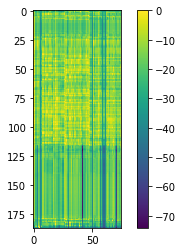

----------------------------------------------------
08-31 04:33:29
Mean Loss: 0.015930245343551214
----------------------------------------------------
08-31 04:33:50
Mean Loss: 0.015957615588533286


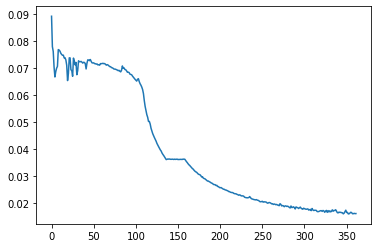

해-의--------------------로-부--더  저-년 뎡이 유-이--태-어   ---헉-산-나-는 엇을 -밤지ᄌ악이위ᅵ안 노ᄅ-력이  있ᆻ--------------------------------------ᄋ--ᅥᆻ다.<eos>
해의로부더 저년 뎡이 유이태어 헉산나는 엇을 밤지ᄌ악이위ᅵ안 노ᄅ력이 있었다.<eos>
해외로부터 전염병이 유입되어 확산되는 것을 방지하기 위한 노력이 있었다.<eos>-------------------


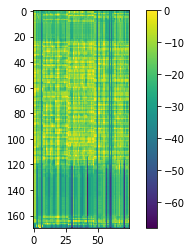

----------------------------------------------------
08-31 04:34:11
Mean Loss: 0.01565902712090632
----------------------------------------------------
08-31 04:34:32
Mean Loss: 0.015811242646157207


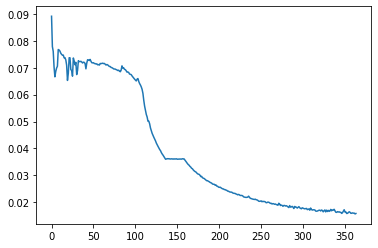

저-는----------  기ᄀ가 어ᅥ-두는ᆫ데ᅦ   ---다른 서-ᅡᅡᆷ에 얘-기를  ---아지ᅵ 자ᅡ이들러저ᅮ-다-는 말을  -마ᅡᄋ이 들어-----------------------------------------------------------왔어요.<eos>
저는 기가 어두는데 다른 서ᅡᆷ에 얘기를 아지 자이들러저ᅮ다는 말을 마이 들어왔어요.<eos>
저는 귀가 어두운데 다른 사람의 얘기를 아주 잘 들어 준다는 말을 많이 들어왔어요.<eos>-----------


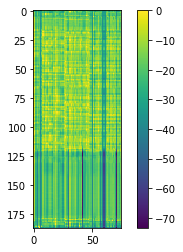

----------------------------------------------------
08-31 04:34:53
Mean Loss: 0.01582607258229619
----------------------------------------------------
08-31 04:35:14
Mean Loss: 0.01573599551044233


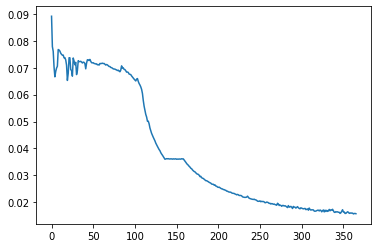

사-룸----------는을 멉니 있는 사람을 ᄇ-를ᄋ  떼   ---소-을 언모-한에 만ᄂ늘어  입가ᅡᅡ애 되ᅬ----------------------------------------------------------------------------ᆸ니다.<eos>
사룸는을 멉니 있는 사람을 ᄇ를ᄋ 떼 소을 언모한에 만늘어 입가애 됩니다.<eos>
사람들은 멀리 있는 사람을 부를 때 손을 오목하게 만들어 입가에 댑니다.<eos>-------------------


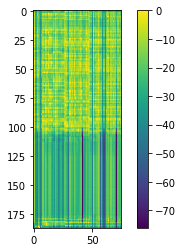

----------------------------------------------------
08-31 04:35:35
Mean Loss: 0.016195640946666742
----------------------------------------------------
08-31 04:35:55
Mean Loss: 0.01590409703472071


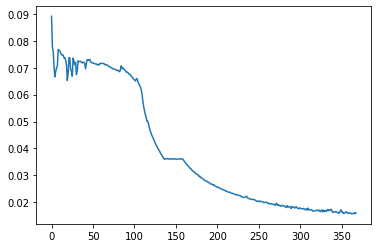

중구--------------ᆨ에에 행앨폭빈열 선애-하고ᅩ조-ᅡᅡᆫ다-며ᅧᆫ  ------고ᄅ력해 해-하  사ᅡ한이ᅵ   멱-가-    --있-------------------------------------------------------------습니다.<eos>
중국에에 행앨폭빈열 선애하고조ᅡᆫ다면 고력해 해하 사한이 멱가 있습니다.<eos>
중국에 해외 법인을 설립하고자 한다면 고려해야 할 사항이 몇 가지 있습니다.<eos>-----------------


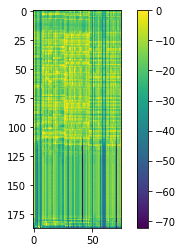

----------------------------------------------------
08-31 04:36:16
Mean Loss: 0.015385543375011737
----------------------------------------------------
08-31 04:36:37
Mean Loss: 0.015668190555195236


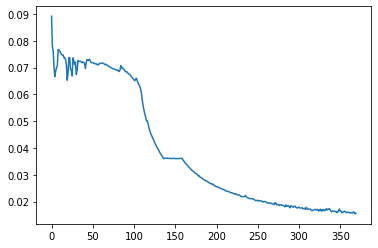

몇겨------------------------ᆨ 비 양-신-적-인 옹ᄆ무-흰ᄃᄃᆯ이   -----자신ᆫ들의 집미-으  ᄋ-옹에    ---내-뭉를 바-닸승이 즐어------------------------------------------ᄂ--ᅡᆻ다.<eos>
몇격 비 양신적인 옹무흰ᄃᆯ이 자신들의 집미으 ᄋ옹에 내뭉를 바닸승이 즐어났다.<eos>
몇몇 비양심적인 공무원들이 자신들의 지위를 이용해 뇌물을 받았음이 드러났다.<eos>----------


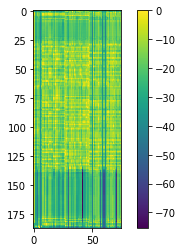

----------------------------------------------------
08-31 04:36:58
Mean Loss: 0.015242441147196317
----------------------------------------------------
08-31 04:37:19
Mean Loss: 0.015430333025764766


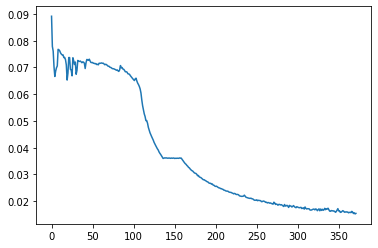

여-러-------------분는 이-ᅩᅥᆺ세-서-,  -------ᅡᅡᆷ-이,  --------ᄑ---까-- --피-률 릭-든  ---라ᅡ라ᅡ간 종미ᄋ이-보-태-을 부-실 수  -있-----------------------습니다.<eos>
여러분는 이ᅩᅥᆺ세서, ᅡᆷ이, ᄑ까 피률 릭든 라라간 종미이보태을 부실 수 있습니다.<eos>
여러분은 이곳에서 장미, 백합, 튤립 등 다양한 종류의 꽃들을 보실 수 있습니다.<eos>----------


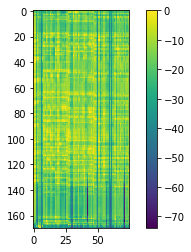

----------------------------------------------------
08-31 04:37:40
Mean Loss: 0.01521696325349959
----------------------------------------------------
08-31 04:38:00
Mean Loss: 0.015507121138925101


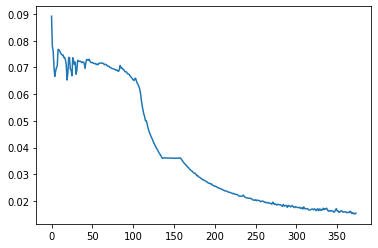

첨음------------------이 오세  이ᄉ-알-엘  때ᅢᅢ    -----거-어-서  달는 거ᄀ기에ᄉ심여-푼 가기ᅵ가 있따-는 게   ----창-- 좋-------------------------------았어요.<eos>
첨음이 오세 이ᄉ알엘 때 거어서 달는 거기에심여푼 가기가 있따는 게 창 좋았어요.<eos>
처음 이곳에 이사 왔을 때 걸어서 닿는 거리에 식료품 가게가 있다는 게 참 좋았어요.<eos>----------


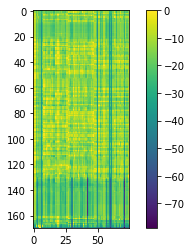

----------------------------------------------------
08-31 04:38:21
Mean Loss: 0.015466128188337458
----------------------------------------------------
08-31 04:38:42
Mean Loss: 0.016232651853422632


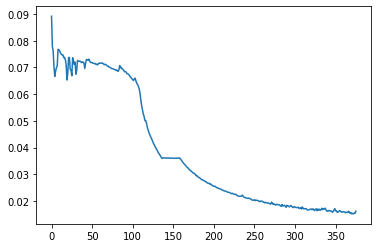

제-가--------------- 또 우 패ᄅ아이 지면을 딴ᆫ든는 이기ᄅ을 들었을 때-,  --------처-른 정말    --밋ᄀᄀ-지기 않---------------------------------------------------------았어요.<eos>
제가 또 우 패ᄅ아이 지면을 딴든는 이기ᄅ을 들었을 때, 처른 정말 밋ᄀ지기 않았어요.<eos>
제가 그 오페라의 주연을 따냈다는 얘기를 들었을 때 저는 정말 믿기지가 않았어요.<eos>------------


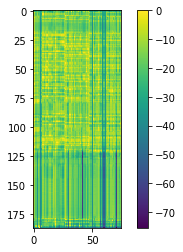

----------------------------------------------------
08-31 04:39:03
Mean Loss: 0.01518054532851454
----------------------------------------------------
08-31 04:39:24


KeyboardInterrupt: 

In [17]:
EPOCH = 3 * 60 * 4
REPEAT = 1
    
try:
    net.load('model_saved/CTC_1024H______')
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    preloader.initialize_batch()
    counter = 0
    loss_list = list()
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    while preloader.end_flag == False:
        tensor_input, ground_truth, loss_mask, length_list = preloader.get_batch()
        
        for i in range(REPEAT):
            pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
        
        counter += 1
        loss_list.append(loss)

    print("Mean Loss: {}".format(np.mean(np.asarray(loss_list))))
    lost_history.append(np.mean(np.asarray(loss_list)))
    net.save('model_saved/CTC_1024H_______')
    np.save('model_saved/loss_history_______', lost_history)
    
    if ((epoch != 0) and (epoch % 15 == 0)):
        plt.figure()
        plt.plot(lost_history)
        plt.show()
        
        _, index = pred_tensor[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
                        
    print("----------------------------------------------------")